# Визуализация сезонных колебаний

На [странице](http://berkeleyearth.lbl.gov/stations/169045), откуда взят источник данных об истории измерений в метеостанции Ростова-на-Дону, предложены классические графики с динамикой колебаний вдоль одной оси времени.

Так как в дате содержится и год и месяц - мы можем визуализировать временной ряд в двух временных осях без вычисления каких-либо моделей.

In [2]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


Поскольку информация о колонках указана в комментариях, то мы при импорте данных в таблицу указываем параметры
- без заголовков ( `header=None,` )
- свой перечень кратких имен (`names=[...]`)

In [3]:
#                   Raw Data           QC    Continuity     Adjusted Data      Regional Expectation
# Year, Month, Temperature, Anomaly, Failed,   Breaks,   Temperature, Anomaly, Temperature, Anomaly

# u='http://berkeleyearth.lbl.gov/auto/Stations/TAVG/Text/169045-TAVG-Data.txt'
u='169045-TAVG-Data.txt'
D = pd.read_table(u, delim_whitespace=True, comment='%', header=None,
                 names='year month v0 dv0 q br v dv reg dreg'.split())
D.tail()

,year,month,v0,dv0,q,br,v,dv,reg,dreg
1536,2013,7,24.486,1.279,0.0,0.0,24.417,1.210,23.569,0.536
1537,2013,8,24.419,1.928,0.0,0.0,24.408,1.916,24.037,1.720
1538,2013,9,14.553,-2.249,0.0,0.0,14.567,-2.235,14.302,-2.325
1539,2013,10,8.736,-0.628,0.0,0.0,8.686,-0.678,8.523,-0.667
1540,2013,11,9.600,6.366,1.0,0.0,NaN,NaN,NaN,NaN


Как мы видим, данные обрываются на дате 2013-11. В 19-м веке сбор данных также был нерегулярным. Поэтому для целей визуализации отберем колонку "Выверенные температурные данные" за 100 лет.

In [4]:
X = D.loc[D.year>1912, ['year','month','v']]
X.head()

,year,month,v
330,1913,1,-4.859
331,1913,2,-6.552
332,1913,3,3.278
333,1913,4,12.135
334,1913,5,13.987


Готовим названия месяцев (для красоты)

In [17]:
# так можно получить готовый список 3-буквенных названий месяцев на английском
# momo = pd.datetools.MONTHS
# momo = map(str.capitalize, momo)

# а так мы получим локализованные названия
import locale
locale.setlocale(locale.LC_TIME, '')
momo=[datetime.datetime(2016,i,1).strftime('%b').encode('latin1').decode('1251') for i in arange(1,13)]
print(' '.join(momo))

янв фев мар апр май июн июл авг сен окт ноя дек


Группируя по году и месяцу, мы создаем двойной индекс, который методом `unstack()` разделяем на индекс строк и индекс колонок, получая таким образом широкую таблицу.

In [18]:
W = X[["year", "month", "v"]].groupby(by=["year", "month"]).max().unstack()
W.columns=momo
W.head()

,янв,фев,мар,апр,май,июн,июл,авг,сен,окт,ноя,дек
year,,,,,,,,,,,,
1913,-4.859,-6.552,3.278,12.135,13.987,17.212,21.268,23.346,16.663,7.469,4.932,1.66
1914,-2.559,0.648,6.878,9.135,16.487,19.612,23.368,20.246,14.563,8.669,-2.168,-3.44
1915,3.141,-2.852,1.978,10.835,13.987,19.412,23.568,19.246,14.063,7.469,4.332,-0.34
1916,-3.059,-2.352,1.878,9.935,15.387,19.012,22.168,19.946,13.363,9.469,3.032,-2.54
1917,-4.459,-8.952,-0.522,11.935,13.087,20.412,21.468,21.546,15.963,10.369,7.332,-0.84


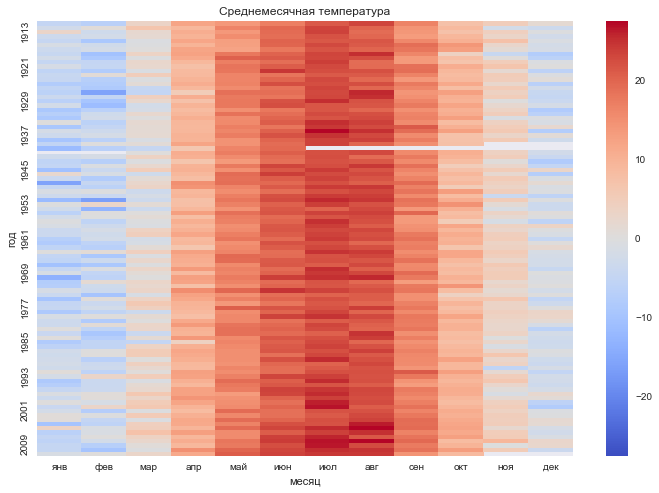

In [19]:
figure(figsize=(12, 8))
sns.heatmap(W, yticklabels=8, cmap="coolwarm")
xlabel('месяц'); ylabel('год'); title('Среднемесячная температура'); 

Обратите внимание:
- параметр `yticklabels` задает интервал между отметками по оси, чтобы метки не наезжали друг на друга
- дивергентная цветовая карта позволяет сосредоточиться на особо жарких и холодных месяцах.
- зимой 1941-го и во время оккупации данные не собирались

Если у нас стоит задача заполнить недостающие данные или спрогнозировать колебания в будущем, то в условиях стабильных предсказуемых циклов, какими являются сезонными, хороший результат дают средние значения для той же фазы цикла. 

В данном наборе данных для прогнозирования температуры в августе в будущем году или заполнения пропуска в 1941 году можно взять среднюю температуру в августе.

## Оценка аномалий

В наборе данных есть колонка, показывающая насколько текущее значение отклоняется от ожидаемого, т.е. показывает аномальность температуры в этом месяце.

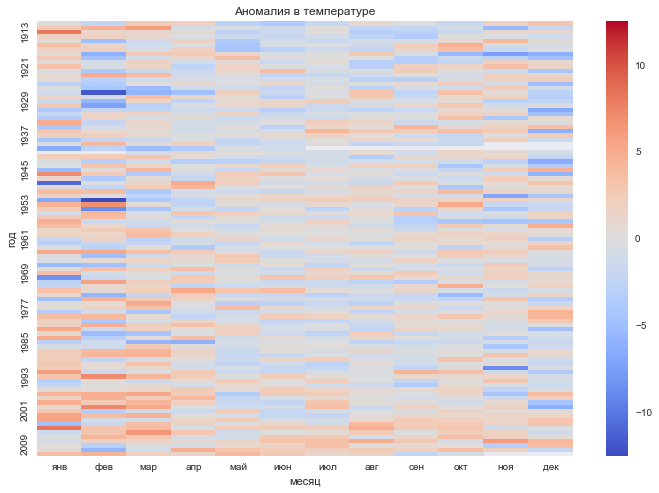

In [20]:
figure(figsize=(12, 8))
W_anomal = D.loc[D.year>1912,["year", "month", "dv"]].groupby(by=["year", "month"]).max().unstack() #делаем широкую таблицу
W_anomal.columns=momo
sns.heatmap(W_anomal, yticklabels=8, cmap="coolwarm")
xlabel('месяц'); ylabel('год'); title('Аномалия в температуре'); 

Сравним аномальность из таблицы с отклонением значений от среднего.

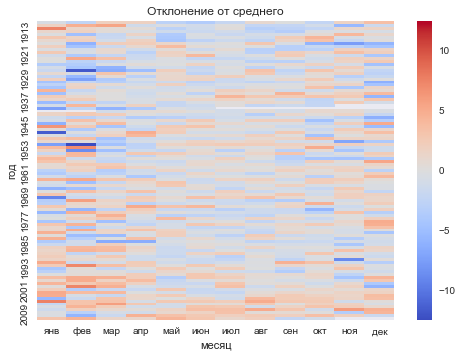

In [21]:
W_dev = W - W.mean()
sns.heatmap(W_dev, yticklabels=8, cmap="coolwarm")
xlabel('месяц'); ylabel('год'); title('Отклонение от среднего'); 

По идентичности рисунков становится понятно, что "аномальность" именно так и рассчитали. Небольшие расхождения в нашем примере связаны с тем, что мы взяли среднее не за всю историю наблюдений, а за 100 лет.

> Обратите внимание, что в зимние месяцы температура нестабильна из года в год.

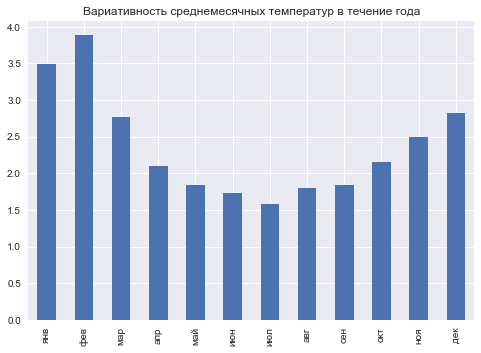

In [22]:
W.std().plot(kind='bar', title='Вариативность среднемесячных температур в течение года');

В данном блокноте продемонстрированы приемы:
- двумерной цветовой визуализации
- создания и настройки подписей осей
- загрузки данных из сети с переопределением имен переменных